In [3]:
import jax
import jax.numpy as jnp
import optax
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd
from sklearn.datasets import fetch_california_housing

import liesel.experimental.optim as opt
import liesel.model as lsl
from liesel.experimental import nn

In [4]:
data = fetch_california_housing(as_frame=True)

In [5]:
X = data["data"]
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [6]:
y = data["target"]
y

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MedHouseVal, Length: 20640, dtype: float64

In [7]:
X_dict = X.to_dict("series")
X_dict = {k: jnp.asarray(v.to_numpy()) for k, v in X_dict.items()}

In [8]:
pos = {"y": jnp.asarray(y.to_numpy())} | X_dict

### Train/Test Split

In [9]:
split = opt.Split.from_share(
    list(pos), n=X.shape[0], share_validate=0.2, share_test=0.1
)
split.indices = split.permute_indices(jax.random.key(42))
data = split.split_position(pos)

In [10]:
def std_y(y):
    train_mean = data.train["y"].mean()
    train_sd = data.train["y"].std()
    return (y - train_mean) / train_sd


pos["y"] = std_y(pos["y"])

data = split.split_position(pos)

### Batches

In [11]:
batches = opt.Batches(list(pos), n=data.n_train, batch_size=32)
batches.indices = batches.permute_indices(jax.random.key(0))
b0 = batches.get_batched_position(data.train, 0)

### Model

In [12]:
# feature definition
features = []
for name in X_dict:
    fn = jnp.log if name not in ["Longitude", "Latitude"] else lambda x: x
    feat = nn.Feature.from_data(b0, data.train, name, standardize=True, fn=fn)
    features.append(feat)

calc = lsl.Calc(lambda *inputs: jnp.vstack(inputs).T, *features)
Xvar = lsl.Var(calc, name="X")

# layers definition
L1 = nn.DenseLayer(Xvar, size=64, activation_fn=jax.nn.relu)
L2 = nn.DenseLayer.from_layer(L1, size=64, activation_fn=jax.nn.relu)

# output layer
loc = nn.Perceptron.from_layer(L2, name="loc")

# other parameters
log_scale = lsl.Var.new_param(jnp.log(10.0), name="log(scale)")
scale = lsl.Var.new_calc(jnp.exp, log_scale, name="scale")

# end node
yvar = lsl.Var.new_obs(
    value=b0["y"], distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale), name="y"
)

# model
model = lsl.Model([yvar])


In [13]:
if L1.size < 6:
    model.plot_vars()

### Loss definition

In [14]:
loss = opt.NegLogProbLoss(
    model=model, split=data, validation_strategy="log_lik", scale=True
)

### Optimizer Definition

In [15]:
scheduler = optax.cosine_decay_schedule(
    init_value=1e-4 * 5, decay_steps=1000 * batches.n_full_batches
)
opt_inst = optax.adamw(learning_rate=scheduler, weight_decay=1e-4)
gradient_clipping = optax.clip_by_global_norm(1.0)
opt_chain = optax.chain(gradient_clipping, opt_inst)

optimizer = opt.Optimizer(
    list(model.parameters),
    optimizer=opt_chain,
)

### Optimizer Engine

In [16]:
engine = opt.OptimEngine(
    loss=loss,
    batches=batches,
    split=data,
    stopper=opt.Stopper(max_iter=100, patience=20, atol=0.0, rtol=1e-6),
    initial_state=model.state,
    optimizers=[optimizer],
    progress_n_updates=100,
    seed=1,
)

### Model fit

In [17]:
res = engine.fit()

Initializing:   0%|          | 0/100 [00:00<?, ?it/s]

Training loss: 0.645, Validation loss: 0.677: 100%|██████████| 100/100 [00:35<00:00,  2.80it/s]


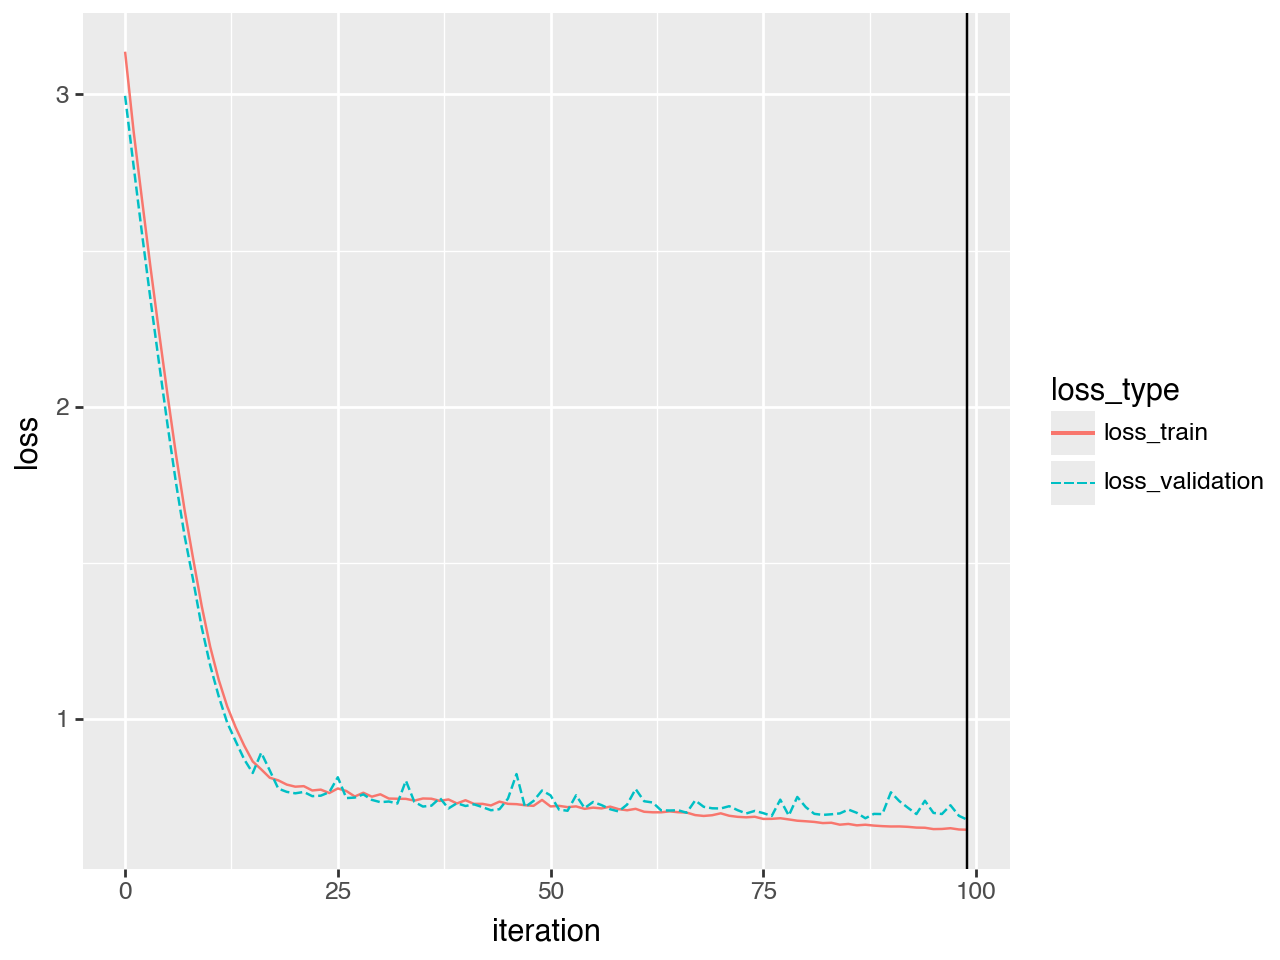

In [18]:
res.plot_loss()

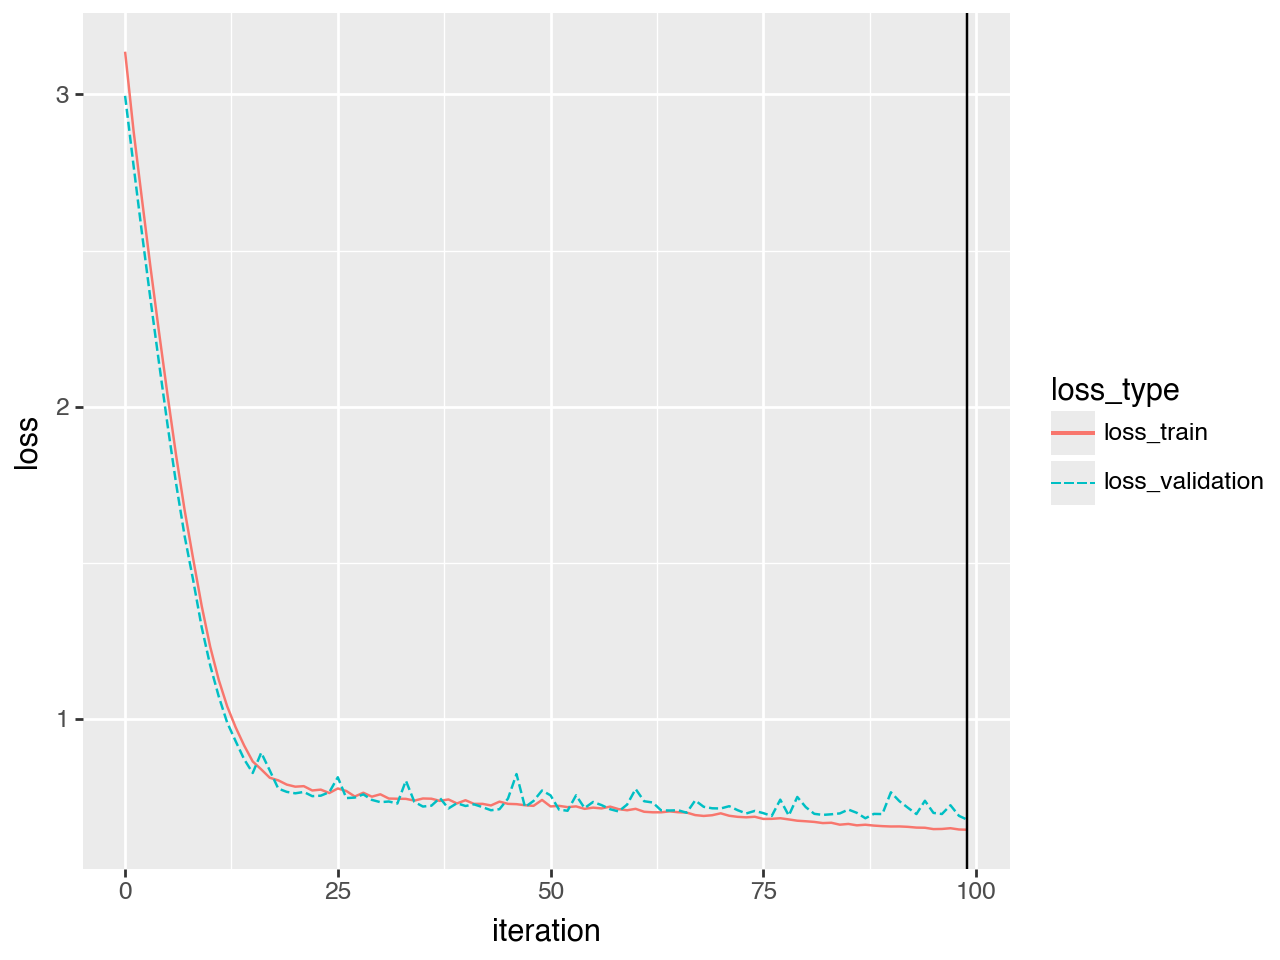

In [19]:
res.plot_loss(window=100)

### Predictions

In [20]:
samples = jax.tree.map(lambda x: jnp.expand_dims(x, (0, 1)), res.best_position)

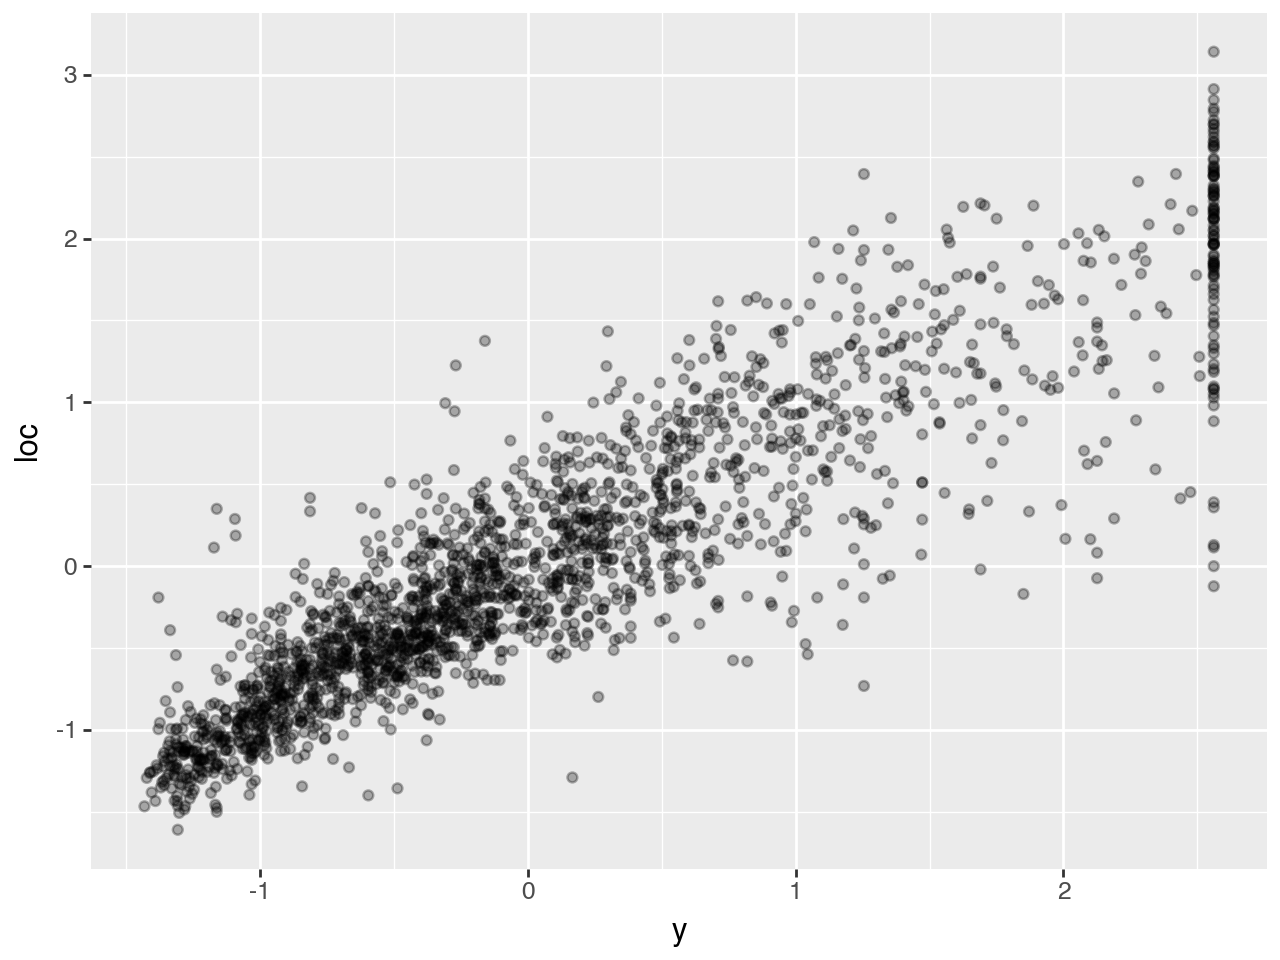

In [21]:
test_x = {k: v for k, v in data.test.items() if k != "y"}
test_prediction = model.predict(samples, predict=["loc", "scale"], newdata=test_x)
test_prediction = jax.tree.map(jnp.squeeze, test_prediction)
df_test = pd.DataFrame(test_prediction | {"y": data.test["y"]})
(p9.ggplot(df_test) + p9.aes("y", "loc") + p9.geom_point(alpha=0.3))

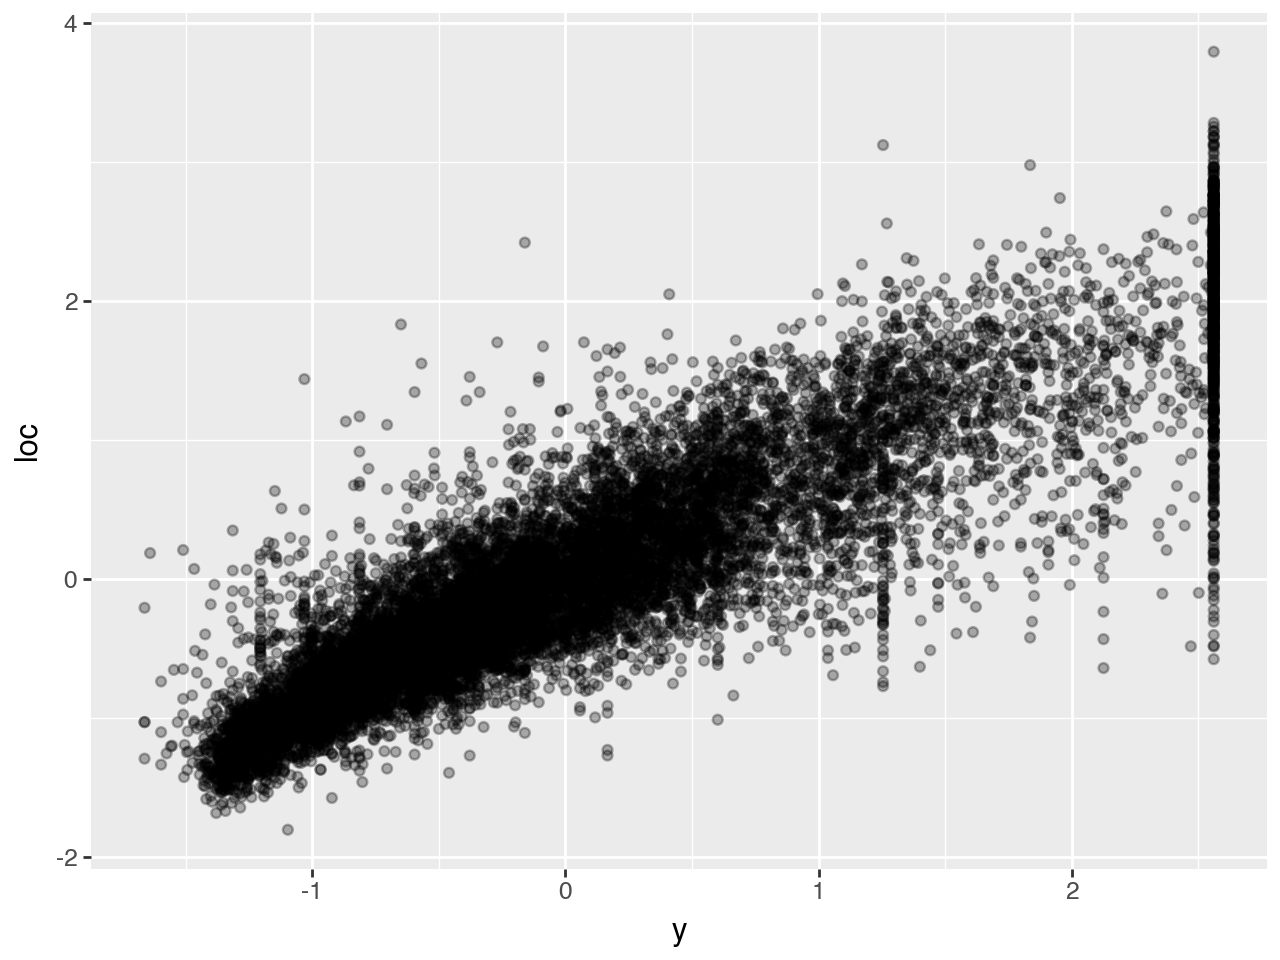

In [22]:
train_x = {k: v for k, v in data.train.items() if k != "y"}
train_prediction = model.predict(samples, predict=["loc", "scale"], newdata=train_x)
train_prediction = jax.tree.map(jnp.squeeze, train_prediction)
df_train = pd.DataFrame(train_prediction | {"y": data.train["y"]})
(p9.ggplot(df_train) + p9.aes("y", "loc") + p9.geom_point(alpha=0.3))